In [204]:
import os
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [205]:
def get_folder_names(folder_name):
    folder_names = []
    for root, dirs, files in os.walk(folder_name):
        for name in dirs:
            folder_names.append(name)
    return folder_names

def get_file_names(folder_name):
    file_names = []
    for root, dirs, files in os.walk(folder_name):
        for name in files:
            file_names.append(name)
    return file_names

In [206]:
def read_xlsx_files(folder_name, mode):
    files = get_file_names(folder_name)
    result_files = [f for f in files if f.endswith("_result.xlsx")]

    all_data = pd.DataFrame()

    for f in result_files:
        data = pd.read_excel(os.path.join(folder_name, f))

        data["model"] = folder_name.split("/")[-1]
        data["file_name"] = f.replace(folder_name.split("/")[-1] + '_', "")
        data["country"] = data["file_name"].apply(lambda x: x.split("_")[0])
        data["lang"] = data["file_name"].apply(lambda x: x.split("_")[1])
        data["mode"] = mode  # Assign the mode passed to the function

        try:
            new_data = data[[
                "country", "lang",
                "index", "correct_option", "extracted", "hit",
                "model", "file_name", "mode"
            ]]
        except:
            new_data = data[[
            "country", "lang",
            "index", "correct_option", "prediction", "hit",
            "model", "file_name", "mode"
        ]]
            
        all_data = pd.concat([all_data, new_data])
    
    return all_data


In [207]:
# List of folder paths with respective mode names
folder_paths_with_modes = {
    "outputs_w_images": "w_images",
    "outputs_blind": "blind",
}

all_all_data = pd.DataFrame()

# Iterate over each folder and its corresponding mode
for folder, mode in tqdm(folder_paths_with_modes.items()):
    folders = get_folder_names(folder)
    
    for f in folders:
        folder_path = os.path.join(folder, f)
        d = read_xlsx_files(folder_path, mode)
        all_all_data = pd.concat([all_all_data, d])

# coalesce the extracted and prediction columns
all_all_data["extracted"] = all_all_data["extracted"].fillna(all_all_data["prediction"])
all_all_data = all_all_data.drop(columns=["prediction"])

# redo the hit column as 1 if extracted is correct, 0 otherwise, not False or True
all_all_data["hit"] = all_all_data.apply(lambda x: 1 if x["extracted"] == x["correct_option"] else 0, axis=1)

100%|██████████| 2/2 [00:03<00:00,  1.93s/it]


In [208]:
display(all_all_data)

,country,lang,index,correct_option,extracted,hit,model,file_name,mode
0,israel,local,1,C,B,0,llava_next_llama3,israel_local_gpt-4o-mini_result.xlsx,w_images
1,israel,local,2,B,A,0,llava_next_llama3,israel_local_gpt-4o-mini_result.xlsx,w_images
2,israel,local,3,A,C,0,llava_next_llama3,israel_local_gpt-4o-mini_result.xlsx,w_images
3,israel,local,4,D,C,0,llava_next_llama3,israel_local_gpt-4o-mini_result.xlsx,w_images
4,israel,local,5,D,C,0,llava_next_llama3,israel_local_gpt-4o-mini_result.xlsx,w_images
...,...,...,...,...,...,...,...,...,...
120,spain,local,123,D,D,1,GPT4o_MINI,spain_local_gpt-4o-mini_result.xlsx,blind
121,spain,local,124,B,B,1,GPT4o_MINI,spain_local_gpt-4o-mini_result.xlsx,blind
122,spain,local,125,A,A,1,GPT4o_MINI,spain_local_gpt-4o-mini_result.xlsx,blind
123,spain,local,126,A,C,0,GPT4o_MINI,spain_local_gpt-4o-mini_result.xlsx,blind


In [209]:
# display a filter of blind, llava_next_llama3
display(all_all_data[(all_all_data["mode"] == "w_images") & (all_all_data["model"] == "llava_next_yi_34b")])

,country,lang,index,correct_option,extracted,hit,model,file_name,mode
0,spain,english,1,A,C,0,llava_next_yi_34b,spain_english_openai_result.xlsx,w_images
1,spain,english,2,C,C,1,llava_next_yi_34b,spain_english_openai_result.xlsx,w_images
2,spain,english,3,B,B,1,llava_next_yi_34b,spain_english_openai_result.xlsx,w_images
3,spain,english,4,D,A,0,llava_next_yi_34b,spain_english_openai_result.xlsx,w_images
4,spain,english,5,A,A,1,llava_next_yi_34b,spain_english_openai_result.xlsx,w_images
...,...,...,...,...,...,...,...,...,...
163,japan,english,300,D,D,1,llava_next_yi_34b,japan_english_openai_result.xlsx,w_images
164,japan,english,302,B,B,1,llava_next_yi_34b,japan_english_openai_result.xlsx,w_images
165,japan,english,303,D,C,0,llava_next_yi_34b,japan_english_openai_result.xlsx,w_images
166,japan,english,304,A,A,1,llava_next_yi_34b,japan_english_openai_result.xlsx,w_images


In [210]:
# drop rows with paligemma-3b-mix-448 from the models
all_all_data = all_all_data[all_all_data["model"] != "paligemma-3b-mix-448"]

In [211]:
all_all_data['mode'].value_counts()

mode
w_images    11360
blind       11360
Name: count, dtype: int64

In [212]:
all_all_data.country.value_counts()

country
israel    7440
japan     6720
spain     5000
brazil    3560
Name: count, dtype: int64

In [213]:
all_all_data.model.value_counts()

model
llava_next_llama3        2272
Yi_VL_34B                2272
GeminiFlash1-5           2272
llava_next_mistral_7b    2272
llava_next_vicuna_7b     2272
GPT4o                    2272
Yi_VL_6B                 2272
llava_next_yi_34b        2272
GeminiPro1-5             2272
GPT4o_MINI               2272
Name: count, dtype: int64

In [214]:
all_all_data.lang.value_counts()

lang
local      11360
english    11360
Name: count, dtype: int64

## Performance

In [215]:
def get_performance_results(data_perf):
    performance_table = data_perf.pivot_table(index=['country', 'model', 'index'],
                                              columns='lang',
                                              aggfunc='first',
                                              values='hit')

    performance_results = performance_table.groupby(['country', 'model']).mean().unstack().transpose()\
                                           .pivot_table(index='model', columns=['lang']).round(3)
    
    level_0_names = performance_results.columns.get_level_values(0)

    performance_results.columns = [
        f"{lvl0}_{lvl1}" for lvl0, lvl1 in zip(level_0_names, performance_results.columns.get_level_values(1))
    ]
    
    return performance_results


In [216]:
all_data_perf = all_all_data[[
    'index','lang','country','model','hit','mode'
]]

data_perf_images = all_data_perf[all_data_perf['mode'] == 'w_images']
data_perf_blind = all_data_perf[all_data_perf['mode'] == 'blind']

performance_results_images = get_performance_results(data_perf_images).reset_index()

performance_results_blind = get_performance_results(data_perf_blind)

In [217]:
display(performance_results_images)

,model,brazil_english,brazil_local,israel_english,israel_local,japan_english,japan_local,spain_english,spain_local
0,GPT4o,0.674,0.753,0.632,0.578,0.720,0.881,0.728,0.712
1,GPT4o_MINI,0.584,0.584,0.438,0.373,0.613,0.732,0.632,0.640
2,GeminiFlash1-5,0.539,0.640,0.427,0.395,0.601,0.667,0.632,0.640
3,GeminiPro1-5,0.652,0.607,0.492,0.368,0.613,0.726,0.632,0.584
4,Yi_VL_34B,0.472,0.438,0.389,0.270,0.536,0.530,0.544,0.416
5,Yi_VL_6B,0.348,0.348,0.362,0.249,0.417,0.482,0.448,0.336
6,llava_next_llama3,0.483,0.382,0.297,0.297,0.482,0.470,0.552,0.416
7,llava_next_mistral_7b,0.416,0.404,0.319,0.265,0.452,0.381,0.512,0.336
8,llava_next_vicuna_7b,0.337,0.292,0.314,0.308,0.399,0.298,0.448,0.328
9,llava_next_yi_34b,0.539,0.483,0.432,0.281,0.577,0.518,0.592,0.488


In [317]:
languages = ['japan', 'spain', 'israel', 'brazil']
local_columns = ['japan_local', 'spain_local', 'israel_local', 'brazil_local']
en_columns = ['japan_english', 'spain_english', 'israel_english', 'brazil_english']
langs = ['Japanese', 'Spanish', 'Hebrew', 'Portuguese']
countries = ['Japan', 'Spain', 'Israel', 'Brazil']
passing_threshold = [.7, .66, .6, .65]

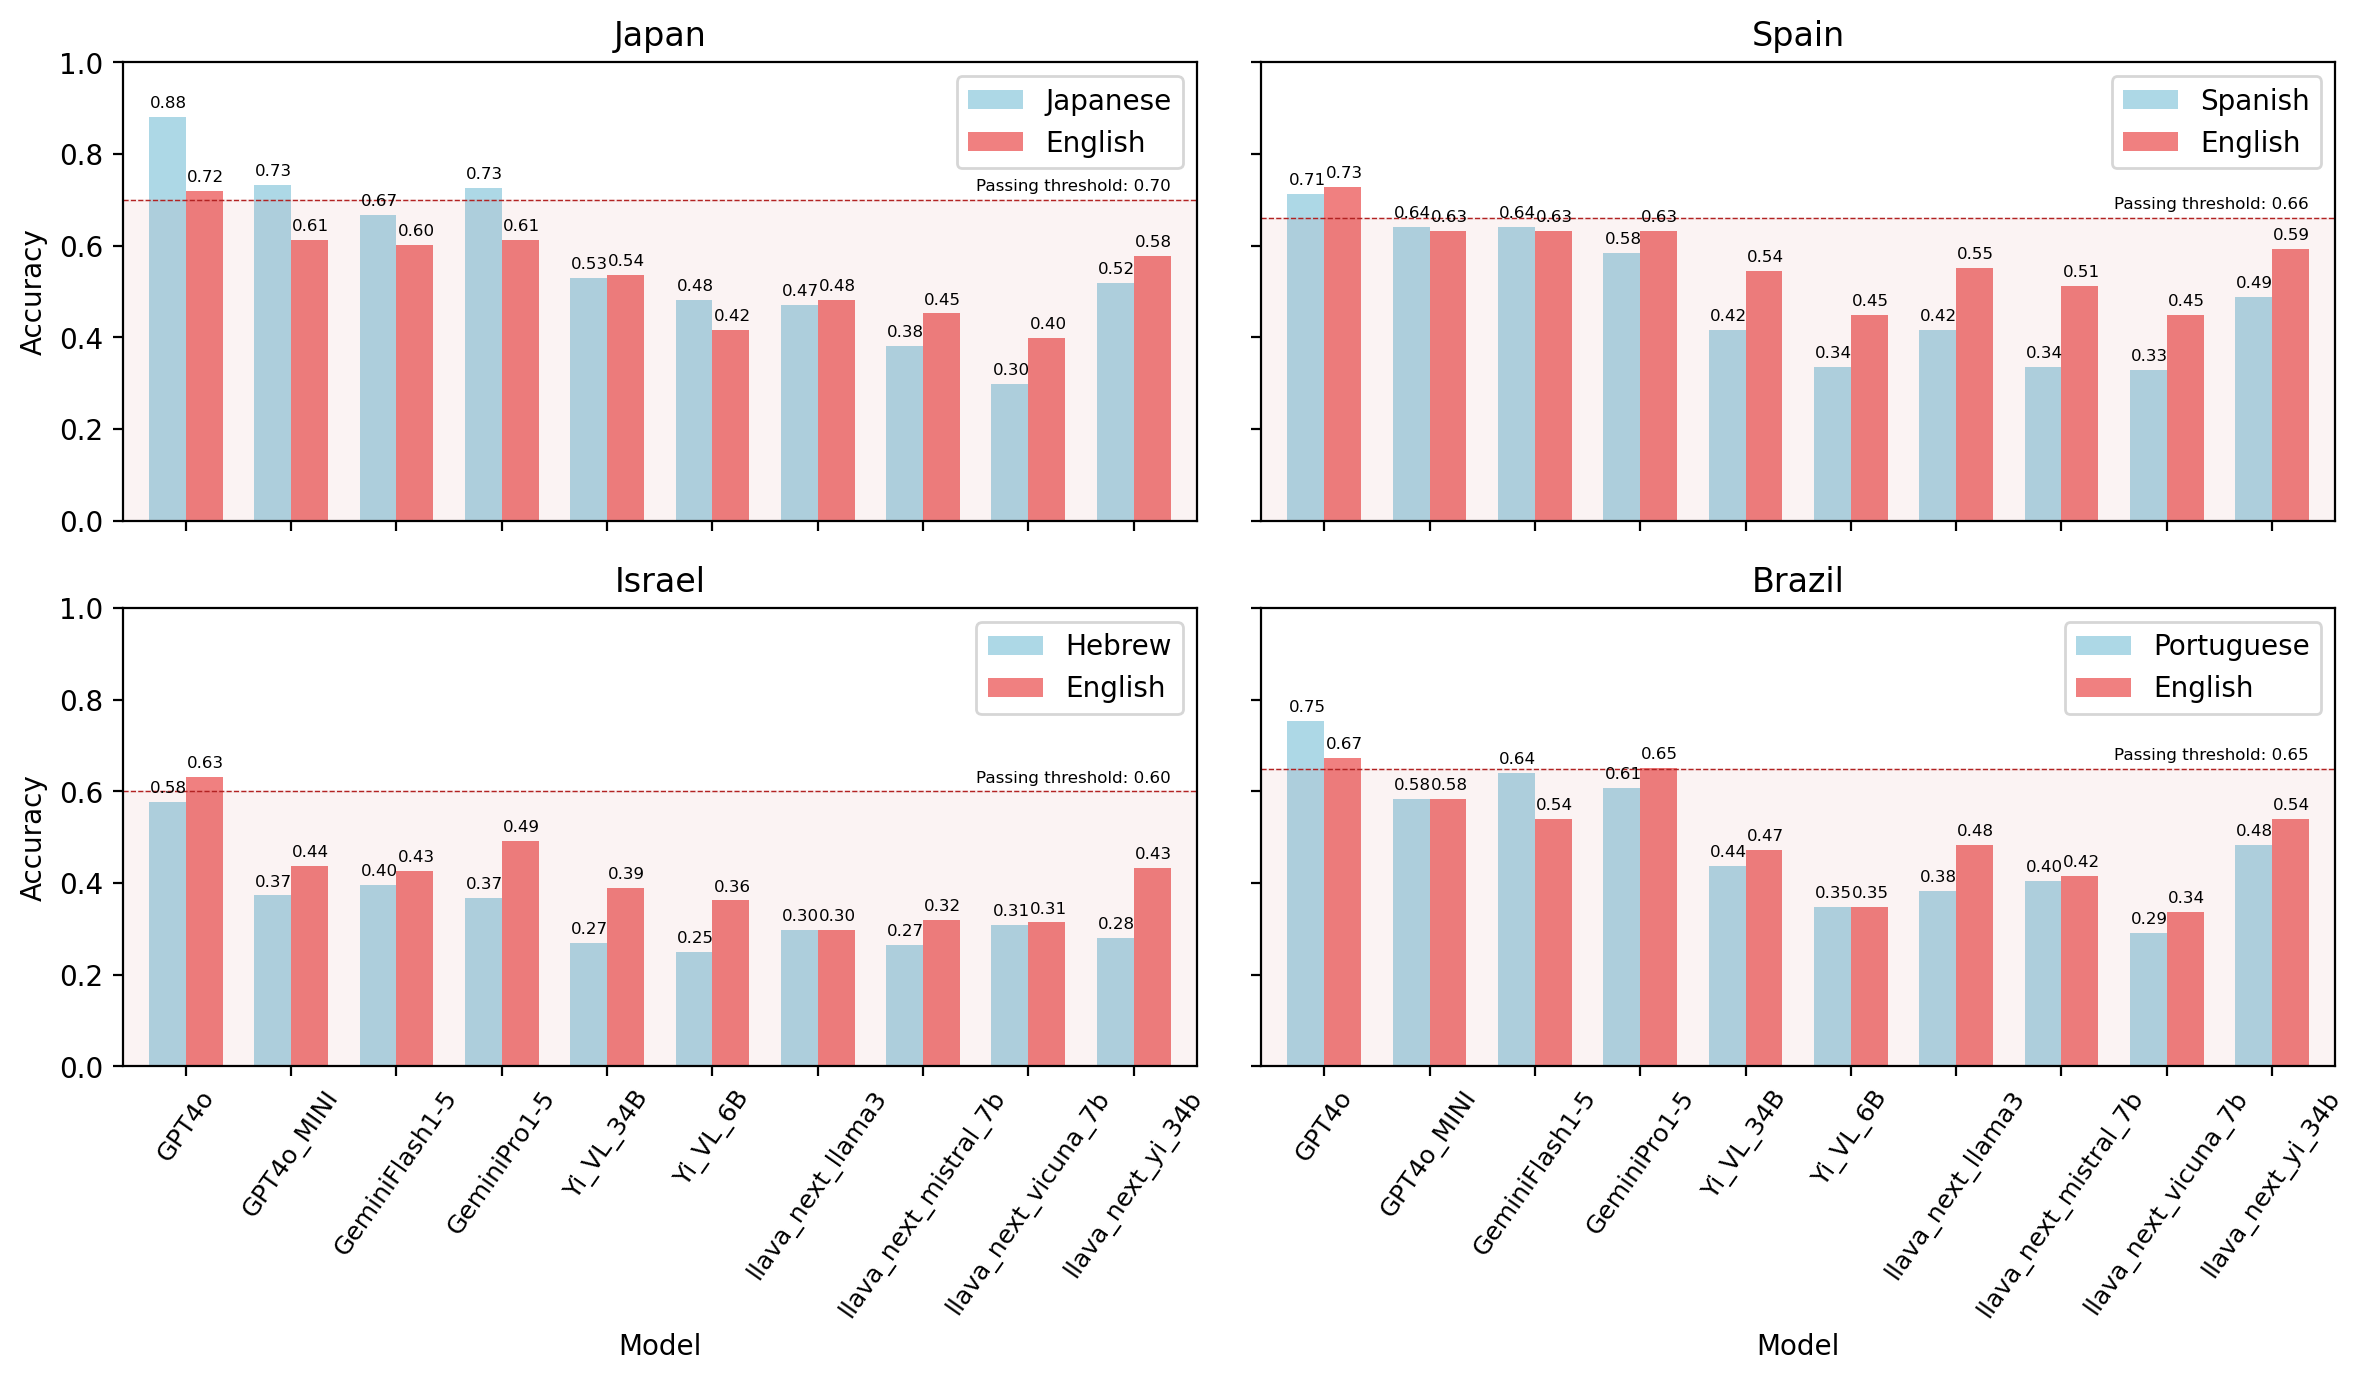

In [348]:
colors = ['lightblue', 'lightcoral', ]  


# Create subplots to visualize the local vs en comparison for each language
fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharey=True, sharex=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

for i, language in enumerate(languages):
    performance_results_images[[local_columns[i], en_columns[i]]] \
                            .set_index(performance_results_images['model']) \
                            .plot(kind='bar', ax=axes[i], width=0.7, color=colors)
    axes[i].set_title(f'{countries[i]}')
    axes[i].set_ylabel('Accuracy')
    axes[i].set_xlabel('Model')
    axes[i].legend([f'{langs[i]}', 'English'])
    axes[i].tick_params(axis='x', rotation=55)
    # add horizontal line for the passing threshold
    axes[i].axhline(y=passing_threshold[i], color='firebrick', linestyle='--', lw=.5)
    # add shadow to the passing threshold
    # axes[i].fill_between([-1, 10], passing_threshold[i], 1, color='darkgreen', alpha=0.1)
    axes[i].fill_between([-1, 10], 0, passing_threshold[i], color='firebrick', alpha=0.05)
    # add text for the passing threshold
    axes[i].text(7.5, passing_threshold[i] + 0.02, f'Passing threshold: {passing_threshold[i]:.2f}', fontsize=6)
    # add data labels
    for p in axes[i].patches:
        axes[i].annotate(f"{p.get_height():.2f}", (p.get_x() + 0.01, p.get_height() + 0.02), fontsize=6)
        # set 2 decimal places  
    # reduce the x ticks fontsize
    axes[i].tick_params(axis='x', labelsize=9)


    # set limit to 0,1
    axes[i].set_ylim(0, 1)



plt.tight_layout()
plt.show()


In [227]:
display(performance_results_blind)


,brazil_english,brazil_local,israel_english,israel_local,japan_english,japan_local,spain_english,spain_local
model,,,,,,,,
GPT4o,0.685,0.764,0.589,0.584,0.690,0.857,0.720,0.704
GPT4o_MINI,0.517,0.562,0.422,0.389,0.595,0.762,0.592,0.632
GeminiFlash1-5,0.494,0.494,0.286,0.281,0.571,0.625,0.544,0.456
GeminiPro1-5,0.382,0.427,0.281,0.135,0.440,0.601,0.248,0.312
Yi_VL_34B,0.034,0.034,0.022,0.011,0.065,0.077,0.024,0.024
Yi_VL_6B,0.326,0.348,0.335,0.238,0.393,0.446,0.392,0.328
llava_next_llama3,0.494,0.393,0.314,0.330,0.435,0.458,0.568,0.368
llava_next_mistral_7b,0.438,0.371,0.319,0.238,0.500,0.369,0.496,0.376
llava_next_vicuna_7b,0.371,0.281,0.303,0.276,0.393,0.256,0.472,0.304


In [228]:
# combine performance_results_images and performance_results_blind
performance_results = performance_results_images.merge(performance_results_blind, on='model', suffixes=('_images', '_blind'))

# display the combined performance results
display(performance_results)

,model,brazil_english_images,brazil_local_images,israel_english_images,israel_local_images,japan_english_images,japan_local_images,spain_english_images,spain_local_images,brazil_english_blind,brazil_local_blind,israel_english_blind,israel_local_blind,japan_english_blind,japan_local_blind,spain_english_blind,spain_local_blind
0,GPT4o,0.674,0.753,0.632,0.578,0.720,0.881,0.728,0.712,0.685,0.764,0.589,0.584,0.690,0.857,0.720,0.704
1,GPT4o_MINI,0.584,0.584,0.438,0.373,0.613,0.732,0.632,0.640,0.517,0.562,0.422,0.389,0.595,0.762,0.592,0.632
2,GeminiFlash1-5,0.539,0.640,0.427,0.395,0.601,0.667,0.632,0.640,0.494,0.494,0.286,0.281,0.571,0.625,0.544,0.456
3,GeminiPro1-5,0.652,0.607,0.492,0.368,0.613,0.726,0.632,0.584,0.382,0.427,0.281,0.135,0.440,0.601,0.248,0.312
4,Yi_VL_34B,0.472,0.438,0.389,0.270,0.536,0.530,0.544,0.416,0.034,0.034,0.022,0.011,0.065,0.077,0.024,0.024
5,Yi_VL_6B,0.348,0.348,0.362,0.249,0.417,0.482,0.448,0.336,0.326,0.348,0.335,0.238,0.393,0.446,0.392,0.328
6,llava_next_llama3,0.483,0.382,0.297,0.297,0.482,0.470,0.552,0.416,0.494,0.393,0.314,0.330,0.435,0.458,0.568,0.368
7,llava_next_mistral_7b,0.416,0.404,0.319,0.265,0.452,0.381,0.512,0.336,0.438,0.371,0.319,0.238,0.500,0.369,0.496,0.376
8,llava_next_vicuna_7b,0.337,0.292,0.314,0.308,0.399,0.298,0.448,0.328,0.371,0.281,0.303,0.276,0.393,0.256,0.472,0.304
9,llava_next_yi_34b,0.539,0.483,0.432,0.281,0.577,0.518,0.592,0.488,0.528,0.438,0.459,0.238,0.577,0.577,0.600,0.504


In [ ]:
print(performance_results.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
country & \multicolumn{2}{r}{brazil} & \multicolumn{2}{r}{israel} & \multicolumn{2}{r}{japan} & \multicolumn{2}{r}{spain} \\
lang & english & local & english & local & english & local & english & local \\
model &  &  &  &  &  &  &  &  \\
\midrule
GPT4o & 0.674000 & 0.753000 & 0.632000 & 0.578000 & 0.720000 & 0.881000 & 0.728000 & 0.712000 \\
GPT4o_MINI & 0.584000 & 0.584000 & 0.438000 & 0.373000 & 0.613000 & 0.732000 & 0.632000 & 0.640000 \\
GeminiFlash1-5 & 0.539000 & 0.640000 & 0.427000 & 0.395000 & 0.601000 & 0.667000 & 0.632000 & 0.640000 \\
GeminiPro1-5 & 0.652000 & 0.607000 & 0.492000 & 0.368000 & 0.613000 & 0.726000 & 0.632000 & 0.584000 \\
Yi_VL_34B & 0.472000 & 0.438000 & 0.389000 & 0.270000 & 0.536000 & 0.530000 & 0.544000 & 0.416000 \\
Yi_VL_6B & 0.348000 & 0.348000 & 0.362000 & 0.249000 & 0.417000 & 0.482000 & 0.448000 & 0.336000 \\
llava_next_llama3 & 0.483000 & 0.382000 & 0.297000 & 0.297000 & 0.482000 & 0.470000 & 0.552000 & 0.416000 \

/var/folders/g2/8l2qx8ps32qdjs9vp5ps103m0000gn/T/ipykernel_32813/4143901265.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(performance_results))


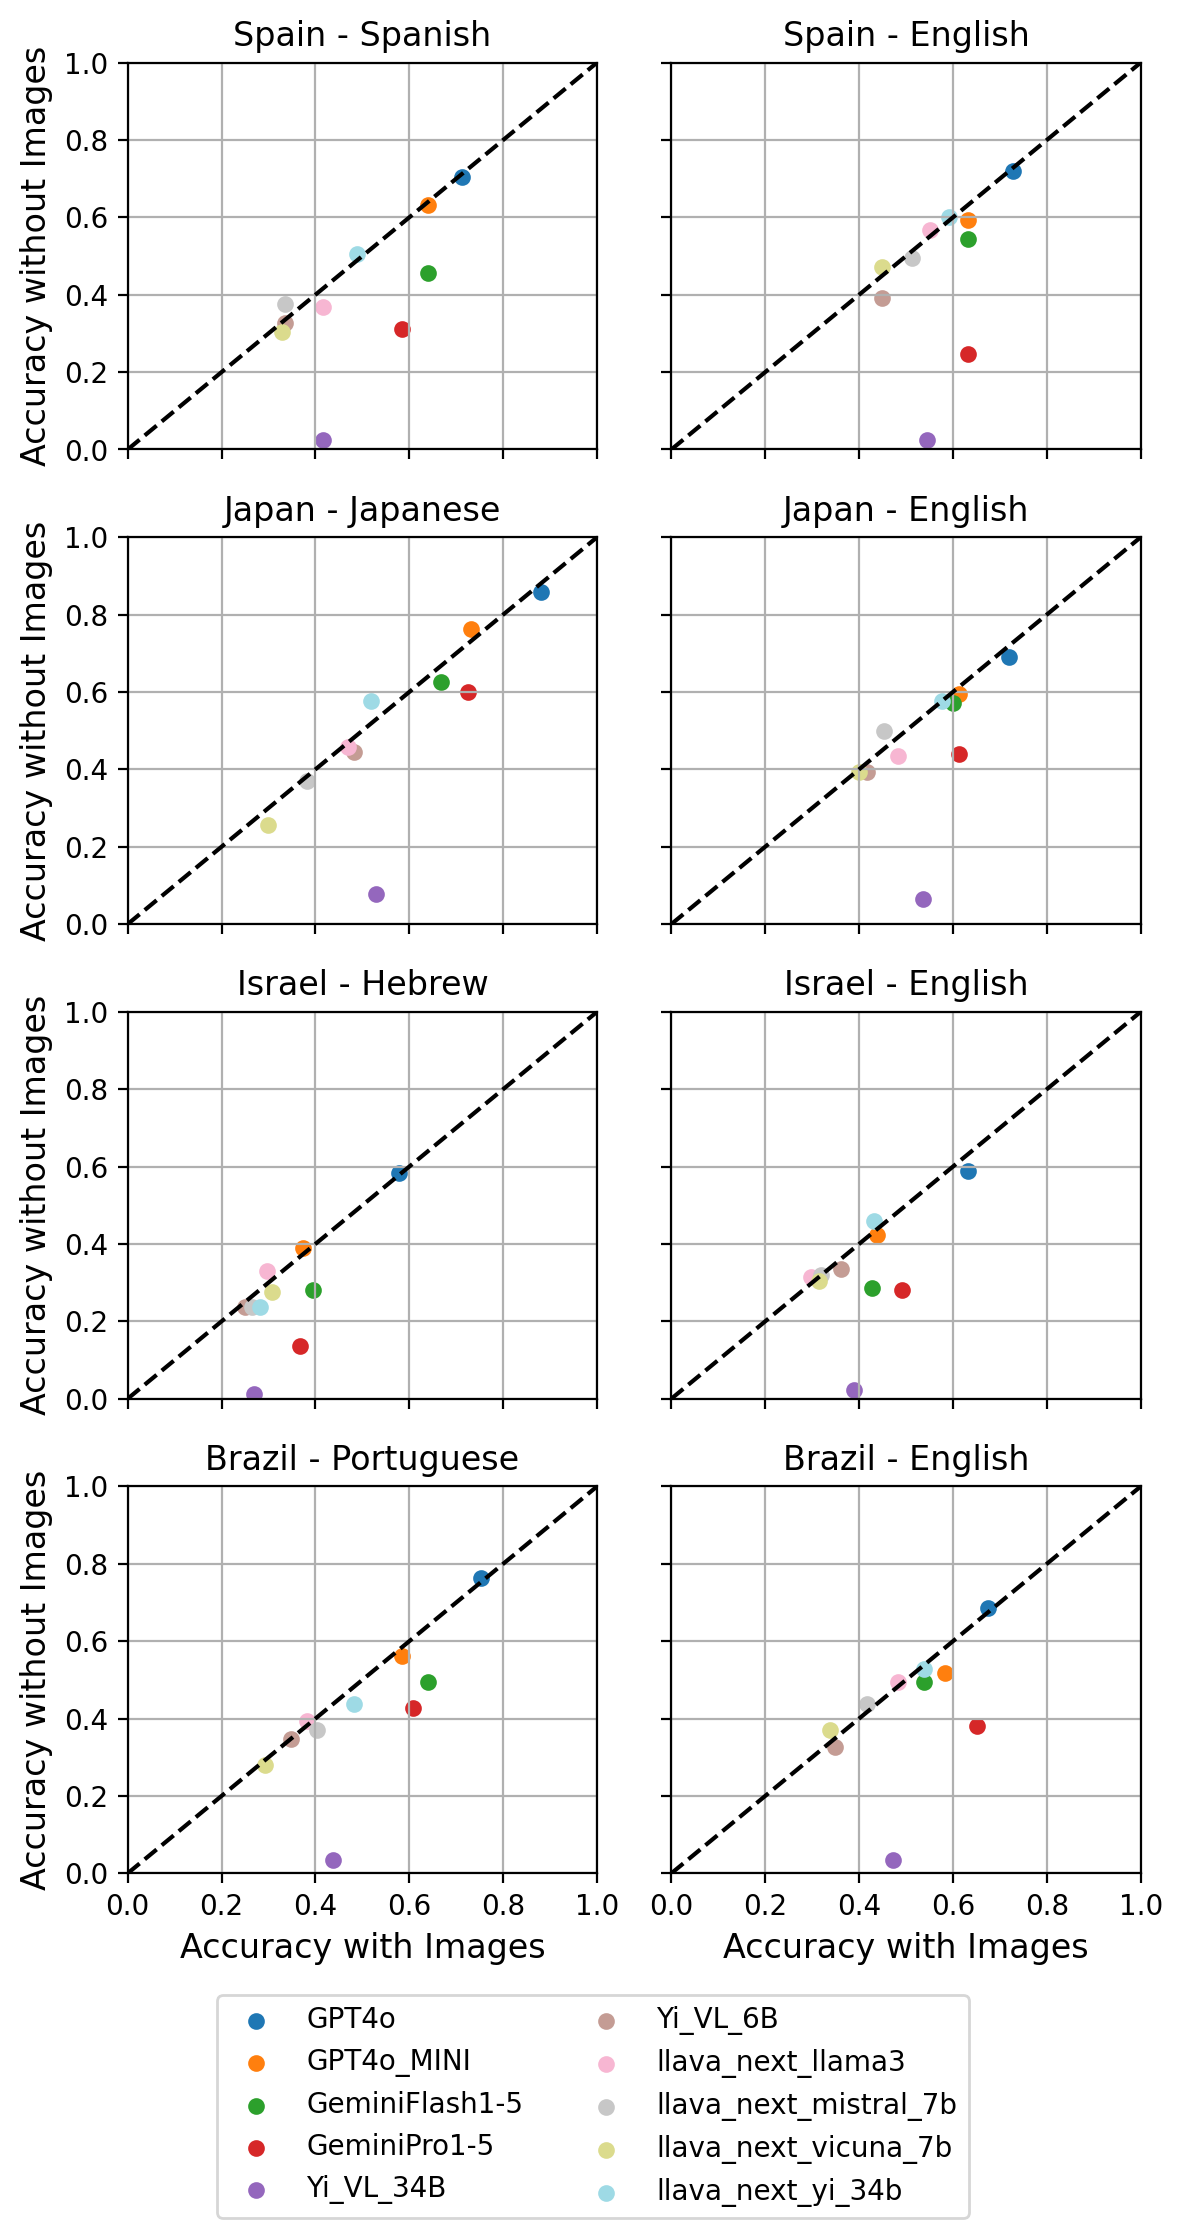

In [257]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming performance_results is already a dataframe with the required data
countries = ['brazil', 'israel', 'japan', 'spain'][::-1]
languages = ['Portuguese', 'Hebrew', 'Japanese', 'Spanish'][::-1]

# Color map for dots
colors = plt.cm.get_cmap('tab20', len(performance_results))

# Set up the 4x2 subplot structure
fig, axs = plt.subplots(4, 2, figsize=(6, 10), sharex=True, sharey=True)

# Flatten the axs array for easy indexing
axs = axs.ravel()

# Plot each country-language pair in its respective subplot
for i, country in enumerate(countries):
    # Local language subplot
    ax_local = axs[i * 2]  # Local language (e.g., Brazil - Portuguese)
    ax_english = axs[i * 2 + 1]  # English
    
    for j, model in enumerate(performance_results.index):
        # Local language (e.g., Brazil - Portuguese)
        x_value_local = performance_results[f'{country}_local_images'][j]
        y_value_local = performance_results[f'{country}_local_blind'][j]
        if pd.notna(x_value_local) and pd.notna(y_value_local):
            ax_local.scatter(x_value_local, y_value_local, color=colors(j), label=performance_results['model'][j], s=25)
        
        # English results for the same country
        x_value_english = performance_results[f'{country}_english_images'][j]
        y_value_english = performance_results[f'{country}_english_blind'][j]
        if pd.notna(x_value_english) and pd.notna(y_value_english):
            ax_english.scatter(x_value_english, y_value_english, color=colors(j), label=performance_results['model'][j], s=25)
    
    # Set titles, labels, and limits for both subplots
    ax_local.set_title(f"{country.capitalize()} - {languages[i]}")
    ax_local.set_ylabel('Accuracy without Images', fontsize=12)

    ax_english.set_title(f"{country.capitalize()} - English")
    
    ax_local.set_xlim(0, 1)
    ax_local.set_ylim(0, 1)
    ax_english.set_xlim(0, 1)
    ax_english.set_ylim(0, 1)

    # add gridlines 
    ax_local.grid(True)
    ax_english.grid(True)
    
    # Add 45-degree comparison lines
    ax_local.plot([0, 1], [0, 1], transform=ax_local.transAxes, ls="--", c="black")
    ax_english.plot([0, 1], [0, 1], transform=ax_english.transAxes, ls="--", c="black")

ax_local.set_xlabel('Accuracy with Images', fontsize=12)
ax_english.set_xlabel('Accuracy with Images', fontsize=12)


# Adjust the layout
plt.tight_layout()

# Aggregate legend handles and labels from all subplots
handles, labels = [], []
for ax in axs:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)

# Add a single legend at the bottom
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.12), ncols=2, fontsize=10)

# Add a suptitle
# plt.suptitle("Model Performance Comparison Across Countries and Languages", fontsize=16)

# Save the figure
plt.savefig('model_comparison_plot.png', bbox_inches='tight')

plt.show()

## Kappas

In [258]:
all_data_pivot = all_all_data[[
    'index','mode','lang','country','model','extracted',
]]
all_data_pivot

,index,mode,lang,country,model,extracted
0,1,w_images,local,israel,llava_next_llama3,B
1,2,w_images,local,israel,llava_next_llama3,A
2,3,w_images,local,israel,llava_next_llama3,C
3,4,w_images,local,israel,llava_next_llama3,C
4,5,w_images,local,israel,llava_next_llama3,C
...,...,...,...,...,...,...
120,123,blind,local,spain,GPT4o_MINI,D
121,124,blind,local,spain,GPT4o_MINI,B
122,125,blind,local,spain,GPT4o_MINI,A
123,126,blind,local,spain,GPT4o_MINI,C


In [259]:
# pivot table based so that the same country and model are in the same rowl, and lang is the column
pivot_table = all_data_pivot.pivot_table(index=['mode','country', 'model','index'],
                                         columns='lang',
                                         aggfunc='first',
                                         values='extracted')

In [260]:
pivot_table

lang                                     english local
mode     country model             index              
blind    brazil  GPT4o             1           D     D
                                   2           A     A
                                   3           A     D
                                   4           B     B
                                   5           B     A
...                                          ...   ...
w_images spain   llava_next_yi_34b 123         D     C
                                   124         C     B
                                   125         A     A
                                   126         A     C
                                   127         D     A

[11340 rows x 2 columns]

In [261]:
def compute_kappa(group):
    try:
        return cohen_kappa_score(group['english'], group['local'])
    except:
        return None


# Pivot table with models as rows and countries as columns
kappa_results = pivot_table.groupby(['country', 'model','mode']).apply(compute_kappa).unstack().transpose()


In [285]:
kappa_results.stack().unstack(level=0)

/var/folders/g2/8l2qx8ps32qdjs9vp5ps103m0000gn/T/ipykernel_32813/3831868027.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  kappa_results.stack().unstack(level=0)


country                  brazil              israel               japan  \
mode                      blind  w_images     blind  w_images     blind   
model                                                                     
GPT4o                  0.683703  0.742949  0.618731  0.653747  0.683094   
GPT4o_MINI             0.642451  0.654981  0.458272  0.603236  0.524601   
GeminiFlash1-5         0.611981  0.536458  0.532660  0.655105  0.590677   
GeminiPro1-5           0.388853  0.468569  0.183904  0.416277  0.351006   
Yi_VL_34B              0.019749  0.438289  0.110577  0.308887  0.033275   
Yi_VL_6B               0.427362  0.319803  0.150394  0.204114  0.240463   
llava_next_llama3      0.429295  0.441201  0.401061  0.379896  0.269012   
llava_next_mistral_7b  0.497759  0.310426  0.147698  0.243427  0.153476   
llava_next_vicuna_7b   0.385253  0.490830  0.166897  0.280743  0.091173   
llava_next_yi_34b      0.592366  0.634559  0.207647  0.223360  0.393358   

country                             spain            
mode                   w_images     blind  w_images  
model                                                
GPT4o                  0.618128  0.839935  0.828606  
GPT4o_MINI             0.553785  0.714997  0.809031  
GeminiFlash1-5         0.520913  0.593609  0.766831  
GeminiPro1-5           0.490315  0.163207  0.693109  
Yi_VL_34B              0.392917  0.029827  0.507284  
Yi_VL_6B               0.348213  0.268887  0.250856  
llava_next_llama3      0.263825  0.435064  0.433276  
llava_next_mistral_7b  0.233751  0.465812  0.347621  
llava_next_vicuna_7b   0.185358  0.310464  0.279446  
llava_next_yi_34b      0.372571  0.594433  0.488447

In [286]:
print(kappa_results.stack().unstack(level=0).round(3).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
country & \multicolumn{2}{r}{brazil} & \multicolumn{2}{r}{israel} & \multicolumn{2}{r}{japan} & \multicolumn{2}{r}{spain} \\
mode & blind & w_images & blind & w_images & blind & w_images & blind & w_images \\
model &  &  &  &  &  &  &  &  \\
\midrule
GPT4o & 0.684000 & 0.743000 & 0.619000 & 0.654000 & 0.683000 & 0.618000 & 0.840000 & 0.829000 \\
GPT4o_MINI & 0.642000 & 0.655000 & 0.458000 & 0.603000 & 0.525000 & 0.554000 & 0.715000 & 0.809000 \\
GeminiFlash1-5 & 0.612000 & 0.536000 & 0.533000 & 0.655000 & 0.591000 & 0.521000 & 0.594000 & 0.767000 \\
GeminiPro1-5 & 0.389000 & 0.469000 & 0.184000 & 0.416000 & 0.351000 & 0.490000 & 0.163000 & 0.693000 \\
Yi_VL_34B & 0.020000 & 0.438000 & 0.111000 & 0.309000 & 0.033000 & 0.393000 & 0.030000 & 0.507000 \\
Yi_VL_6B & 0.427000 & 0.320000 & 0.150000 & 0.204000 & 0.240000 & 0.348000 & 0.269000 & 0.251000 \\
llava_next_llama3 & 0.429000 & 0.441000 & 0.401000 & 0.380000 & 0.269000 & 0.264000 & 0.435000 & 0.4330

/var/folders/g2/8l2qx8ps32qdjs9vp5ps103m0000gn/T/ipykernel_32813/3194198164.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  print(kappa_results.stack().unstack(level=0).round(3).to_latex())


In [108]:
# kappa results for each model to latex
print(kappa_results.round(3).to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
country & \multicolumn{10}{r}{brazil} & \multicolumn{10}{r}{israel} & \multicolumn{10}{r}{japan} & \multicolumn{10}{r}{spain} \\
model & GPT4o & GPT4o_MINI & GeminiFlash1-5 & GeminiPro1-5 & Yi_VL_34B & Yi_VL_6B & llava_next_llama3 & llava_next_mistral_7b & llava_next_vicuna_7b & llava_next_yi_34b & GPT4o & GPT4o_MINI & GeminiFlash1-5 & GeminiPro1-5 & Yi_VL_34B & Yi_VL_6B & llava_next_llama3 & llava_next_mistral_7b & llava_next_vicuna_7b & llava_next_yi_34b & GPT4o & GPT4o_MINI & GeminiFlash1-5 & GeminiPro1-5 & Yi_VL_34B & Yi_VL_6B & llava_next_llama3 & llava_next_mistral_7b & llava_next_vicuna_7b & llava_next_yi_34b & GPT4o & GPT4o_MINI & GeminiFlash1-5 & GeminiPro1-5 & Yi_VL_34B & Yi_VL_6B & llava_next_llama3 & llava_next_mistral_7b & llava_next_vicuna_7b & llava_next_yi_34b \\
mode &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
blind

In [311]:
performance_results_images['mode'] = 'w_images'
performance_results_blind['mode'] = 'blind'

performance_results_table = pd.concat([performance_results_images, performance_results_blind.reset_index()])

In [312]:
performance_results_table.pivot_table(index='model', columns='mode')
# only exclude the _local columns

brazil_english          brazil_local           \
mode                           blind w_images        blind w_images   
model                                                                 
GPT4o                          0.685    0.674        0.764    0.753   
GPT4o_MINI                     0.517    0.584        0.562    0.584   
GeminiFlash1-5                 0.494    0.539        0.494    0.640   
GeminiPro1-5                   0.382    0.652        0.427    0.607   
Yi_VL_34B                      0.034    0.472        0.034    0.438   
Yi_VL_6B                       0.326    0.348        0.348    0.348   
llava_next_llama3              0.494    0.483        0.393    0.382   
llava_next_mistral_7b          0.438    0.416        0.371    0.404   
llava_next_vicuna_7b           0.371    0.337        0.281    0.292   
llava_next_yi_34b              0.528    0.539        0.438    0.483   

                      israel_english          israel_local           \
mode                           blind w_images        blind w_images   
model                                                                 
GPT4o                          0.589    0.632        0.584    0.578   
GPT4o_MINI                     0.422    0.438        0.389    0.373   
GeminiFlash1-5                 0.286    0.427        0.281    0.395   
GeminiPro1-5                   0.281    0.492        0.135    0.368   
Yi_VL_34B                      0.022    0.389        0.011    0.270   
Yi_VL_6B                       0.335    0.362        0.238    0.249   
llava_next_llama3              0.314    0.297        0.330    0.297   
llava_next_mistral_7b          0.319    0.319        0.238    0.265   
llava_next_vicuna_7b           0.303    0.314        0.276    0.308   
llava_next_yi_34b              0.459    0.432        0.238    0.281   

                      japan_english          japan_local           \
mode                          blind w_images       blind w_images   
model                                                               
GPT4o                         0.690    0.720       0.857    0.881   
GPT4o_MINI                    0.595    0.613       0.762    0.732   
GeminiFlash1-5                0.571    0.601       0.625    0.667   
GeminiPro1-5                  0.440    0.613       0.601    0.726   
Yi_VL_34B                     0.065    0.536       0.077    0.530   
Yi_VL_6B                      0.393    0.417       0.446    0.482   
llava_next_llama3             0.435    0.482       0.458    0.470   
llava_next_mistral_7b         0.500    0.452       0.369    0.381   
llava_next_vicuna_7b          0.393    0.399       0.256    0.298   
llava_next_yi_34b             0.577    0.577       0.577    0.518   

                      spain_english          spain_local           
mode                          blind w_images       blind w_images  
model                                                              
GPT4o                         0.720    0.728       0.704    0.712  
GPT4o_MINI                    0.592    0.632       0.632    0.640  
GeminiFlash1-5                0.544    0.632       0.456    0.640  
GeminiPro1-5                  0.248    0.632       0.312    0.584  
Yi_VL_34B                     0.024    0.544       0.024    0.416  
Yi_VL_6B                      0.392    0.448       0.328    0.336  
llava_next_llama3             0.568    0.552       0.368    0.416  
llava_next_mistral_7b         0.496    0.512       0.376    0.336  
llava_next_vicuna_7b          0.472    0.448       0.304    0.328  
llava_next_yi_34b             0.600    0.592       0.504    0.488

In [313]:
# only keep the _local columns, model and mode
performance_results_table_local = performance_results_table[['model', 'mode', 'brazil_local', 
                                                             'israel_local', 'japan_local', 'spain_local']]

performance_results_table_local.pivot_table(index='model', columns='mode')

brazil_local          israel_local          japan_local  \
mode                         blind w_images        blind w_images       blind   
model                                                                           
GPT4o                        0.764    0.753        0.584    0.578       0.857   
GPT4o_MINI                   0.562    0.584        0.389    0.373       0.762   
GeminiFlash1-5               0.494    0.640        0.281    0.395       0.625   
GeminiPro1-5                 0.427    0.607        0.135    0.368       0.601   
Yi_VL_34B                    0.034    0.438        0.011    0.270       0.077   
Yi_VL_6B                     0.348    0.348        0.238    0.249       0.446   
llava_next_llama3            0.393    0.382        0.330    0.297       0.458   
llava_next_mistral_7b        0.371    0.404        0.238    0.265       0.369   
llava_next_vicuna_7b         0.281    0.292        0.276    0.308       0.256   
llava_next_yi_34b            0.438    0.483        0.238    0.281       0.577   

                               spain_local           
mode                  w_images       blind w_images  
model                                                
GPT4o                    0.881       0.704    0.712  
GPT4o_MINI               0.732       0.632    0.640  
GeminiFlash1-5           0.667       0.456    0.640  
GeminiPro1-5             0.726       0.312    0.584  
Yi_VL_34B                0.530       0.024    0.416  
Yi_VL_6B                 0.482       0.328    0.336  
llava_next_llama3        0.470       0.368    0.416  
llava_next_mistral_7b    0.381       0.376    0.336  
llava_next_vicuna_7b     0.298       0.304    0.328  
llava_next_yi_34b        0.518       0.504    0.488

In [315]:
print(performance_results_table_local.pivot_table(index='model', columns='mode').round(3).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{2}{r}{brazil_local} & \multicolumn{2}{r}{israel_local} & \multicolumn{2}{r}{japan_local} & \multicolumn{2}{r}{spain_local} \\
mode & blind & w_images & blind & w_images & blind & w_images & blind & w_images \\
model &  &  &  &  &  &  &  &  \\
\midrule
GPT4o & 0.764000 & 0.753000 & 0.584000 & 0.578000 & 0.857000 & 0.881000 & 0.704000 & 0.712000 \\
GPT4o_MINI & 0.562000 & 0.584000 & 0.389000 & 0.373000 & 0.762000 & 0.732000 & 0.632000 & 0.640000 \\
GeminiFlash1-5 & 0.494000 & 0.640000 & 0.281000 & 0.395000 & 0.625000 & 0.667000 & 0.456000 & 0.640000 \\
GeminiPro1-5 & 0.427000 & 0.607000 & 0.135000 & 0.368000 & 0.601000 & 0.726000 & 0.312000 & 0.584000 \\
Yi_VL_34B & 0.034000 & 0.438000 & 0.011000 & 0.270000 & 0.077000 & 0.530000 & 0.024000 & 0.416000 \\
Yi_VL_6B & 0.348000 & 0.348000 & 0.238000 & 0.249000 & 0.446000 & 0.482000 & 0.328000 & 0.336000 \\
llava_next_llama3 & 0.393000 & 0.382000 & 0.330000 & 0.297000 & 0.458000 & 0.470000 & 

In [314]:
# only keep the _local columns, model and mode
performance_results_table_english = performance_results_table[['model', 'mode', 'brazil_english', 
                                                       'israel_english', 'japan_english', 'spain_english']]

performance_results_table_english.pivot_table(index='model', columns='mode')

brazil_english          israel_english           \
mode                           blind w_images          blind w_images   
model                                                                   
GPT4o                          0.685    0.674          0.589    0.632   
GPT4o_MINI                     0.517    0.584          0.422    0.438   
GeminiFlash1-5                 0.494    0.539          0.286    0.427   
GeminiPro1-5                   0.382    0.652          0.281    0.492   
Yi_VL_34B                      0.034    0.472          0.022    0.389   
Yi_VL_6B                       0.326    0.348          0.335    0.362   
llava_next_llama3              0.494    0.483          0.314    0.297   
llava_next_mistral_7b          0.438    0.416          0.319    0.319   
llava_next_vicuna_7b           0.371    0.337          0.303    0.314   
llava_next_yi_34b              0.528    0.539          0.459    0.432   

                      japan_english          spain_english           
mode                          blind w_images         blind w_images  
model                                                                
GPT4o                         0.690    0.720         0.720    0.728  
GPT4o_MINI                    0.595    0.613         0.592    0.632  
GeminiFlash1-5                0.571    0.601         0.544    0.632  
GeminiPro1-5                  0.440    0.613         0.248    0.632  
Yi_VL_34B                     0.065    0.536         0.024    0.544  
Yi_VL_6B                      0.393    0.417         0.392    0.448  
llava_next_llama3             0.435    0.482         0.568    0.552  
llava_next_mistral_7b         0.500    0.452         0.496    0.512  
llava_next_vicuna_7b          0.393    0.399         0.472    0.448  
llava_next_yi_34b             0.577    0.577         0.600    0.592

In [316]:
print(performance_results_table_english.pivot_table(index='model', columns='mode').round(3).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{2}{r}{brazil_english} & \multicolumn{2}{r}{israel_english} & \multicolumn{2}{r}{japan_english} & \multicolumn{2}{r}{spain_english} \\
mode & blind & w_images & blind & w_images & blind & w_images & blind & w_images \\
model &  &  &  &  &  &  &  &  \\
\midrule
GPT4o & 0.685000 & 0.674000 & 0.589000 & 0.632000 & 0.690000 & 0.720000 & 0.720000 & 0.728000 \\
GPT4o_MINI & 0.517000 & 0.584000 & 0.422000 & 0.438000 & 0.595000 & 0.613000 & 0.592000 & 0.632000 \\
GeminiFlash1-5 & 0.494000 & 0.539000 & 0.286000 & 0.427000 & 0.571000 & 0.601000 & 0.544000 & 0.632000 \\
GeminiPro1-5 & 0.382000 & 0.652000 & 0.281000 & 0.492000 & 0.440000 & 0.613000 & 0.248000 & 0.632000 \\
Yi_VL_34B & 0.034000 & 0.472000 & 0.022000 & 0.389000 & 0.065000 & 0.536000 & 0.024000 & 0.544000 \\
Yi_VL_6B & 0.326000 & 0.348000 & 0.335000 & 0.362000 & 0.393000 & 0.417000 & 0.392000 & 0.448000 \\
llava_next_llama3 & 0.494000 & 0.483000 & 0.314000 & 0.297000 & 0.435000 & 0.4